# **Modelagem**


![img](https://media.discordapp.net/attachments/748012097589215325/816803156112441374/unknown.png?width=576&height=676)

## **Instalação e importação**

In [ ]:
%reset -f

In [ ]:
#Instalar e importar bibliotecas:

try:
  import CoolProp
except ImportError:
  !pip install CoolProp

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import CoolProp.CoolProp as cp
from CoolProp.CoolProp import PropsSI as ps
from CoolProp.CoolProp import State as st
from tabulate import tabulate as tab
import numpy as np
from sympy import *
import pandas as pd

     |████████████████████████████████| 4.2MB 5.3MB/s 


## **Unidade de medida**

In [ ]:
Temperatura = input('Temperatura em °C ou em K? (Digite c ou k): ')

Temperatura em °C ou em K? (Digite c ou k): c


## **Declaração de variáveis**

In [ ]:
# Declarar estados:

n = 12

fld = "Water"
cp.set_reference_state(fld,'DEF')
if Temperatura == 'k':
  Tnn = "Temperatura [K]"
else:
  Tnn = "Temperatura [°C]"

mnn = "Vazão mássica [kg/s]"
hnn = "Entalpia [kJ/kg]"
rhonn = "Massa específica [m³/kg]"
Pnn = "Pressão [kPa]"
snn = "Entropia [kJ/kg*K]"
Xnn = "Título"

estado = np.arange(1, n+1, 1)

T = np.linspace(0,0,n)
m = np.linspace(0,0,n)
h = np.linspace(0,0,n)
rho = np.linspace(0,0,n)
P = np.linspace(0,0,n)
s = np.linspace(0,0,n)
X = np.linspace(0,0,n)

## **Estados**

In [ ]:
# Estado 1 - Entrada da turbina:

m[0] = 27.9        #kg/s
P[0] = 6495        #kPa
T[0] = 485 + 273.15       #K
st1 = st(fld, {'P':P[0],'T':T[0]})
h[0] = st1.h         #entalpia
s[0] = st1.s         #entropia
X[0] = st1.Q
rho[0] = st1.rho

In [ ]:
# Estado 2 - Primeira extração da turbina:

P[1] = 900      #kPa
st_isen2 = st(fld,{'P':P[1],'S':s[0]})     #turbina/bomba isentrópica ideal
h_isen2 = st_isen2.h
η_turb = 0.85       #eficiência da turbina
h[1] = h[0] - (h[0] - h_isen2) * η_turb
st2 = st(fld,{'P':P[1],'H':h[1]})
s[1] = st2.s
T[1] = st2.T
X[1] = st2.Q
rho[1] = st2.rho

In [ ]:
# Estado 3 - Segunda extração da turbina:

P[2] = 250     #kPa
st_isen3 = st(fld,{'P':P[2],'S':s[1]})
h_isen3 = st_isen3.h
h[2] = h[1] - (h[1] - h_isen3) * η_turb
st3 = st(fld,{'P':P[2],'H':h[2]})
s[2] = st3.s
rho[2] = st3.rho
T[2] = st3.T
X[2] = st3.Q

In [ ]:
# Estado 4 - Saída final da turbina / entrada do condensador:

T[3] = 51 + 273.15 #K
#P[3] = psi('P','T',T[3],'Q', 1, fld)/1000  #divide por 1000 pra sair em kPa
st4 = st(fld, {'T': T[3], 'Q': 1})
P[3] = st4.p
st_isen4 = st(fld,{'P':P[3],'S':s[2]})
h_isen4 = st_isen4.h
h[3] = h[2] - (h[2] - h_isen4) * η_turb
st4 = st(fld,{'P':P[3],'H':h[3]})
X[3] = st4.Q      #título
s[3]=st4.s
rho[3] = st4.rho

In [ ]:
# Estado 5 - Saída do condensador / entrada da bomba:

X[4] = 0
P[4] = P[3]
st5 = st(fld, {'P': P[4], 'Q': 0})
h[4] = st5.h
s[4] = st5.s
T[4] = st5.T
rho[4] = st5.rho

In [ ]:
# Estado 6 - Entrada do desaerador / saída da bomba:

P[5] = P[2]
st_isen6 = st(fld, {'P': P[5], 'S': s[4]})
h_isen6 = st_isen6.h
η_pump = 0.85       #eficiência das bombas
h[5] = (h_isen6 - h[4]) / η_pump + h[4]
st6 = st(fld, {'P':P[5], 'H': h[5]})
s[5] = st6.s
T[5] = st6.T
X[5] = st6.Q
rho[5] = st6.rho

In [ ]:
# Estado 7 - Saída do desaerador:

P[6] = P[2]
T[6] = 110 + 273.15
st7 = st(fld, {'P': P[6], 'T': T[6]})
h[6] = st7.h
s[6] = st7.s
X[6] = st7.Q
rho[6] = st7.rho

In [ ]:
# Estado 8 - Entrada da caldeira:

P[7] = P[0]
st_isen8 = st(fld, {'P': P[7], 'S': s[6]})
h_isen8 = st_isen8.h
h[7] = (h_isen8 - h[6]) / η_pump + h[6]
st8 = st(fld, {'P': P[7], 'H': h[7]})
T[7] = st8.T - 273.15
s[7] = st8.s
X[7] = st8.Q
rho[7] = st8.rho

In [ ]:
# Estado 9 - Entrada da bomba:

st9 = st7
h[8] = st9.h
s[8] = st9.s
P[8] = st9.p
T[8] = st9.T
X[8] = st9.Q
rho[8] = st9.rho

In [ ]:
# Estado 10 - Saída da bomba / entrada do trocador de calor:

P[9] = P[1]
st_isen10 = st(fld, {'P': P[9], 'S': s[8]})
h_isen10 = st_isen10.h
h[9] = (h_isen10 - h[8]) / η_pump + h[8]
st10 = st(fld, {'P': P[9], 'H': h[9]})
s[9] = st10.s
T[9] = st10.T
X[9] = st10.Q
rho[9] = st10.rho

In [ ]:
# Estado 11 - Entrada do processo industrial vizinho:

X[10] = 1
P[10] = P[9]
st11 = st(fld, {'P': P[10], 'Q': X[10]})
h[10] = st11.h
s[10] = st11.s
T[10] = st11.T
rho[10] = st11.rho

In [ ]:
# Estado 12 - Saída do processo industrial vizinho:

X[11] = 0
P[11] = P[9]
st12 = st(fld, {'P':P[11], 'Q': X[11]})
h[11] = st12.h
s[11] = st12.s
T[11] = st12.T
rho[11] = st12.rho

## **Tabela - Estados**

In [ ]:
# Tabela 1:
headers=["Estado", Tnn, Pnn, Xnn, hnn, snn, rhonn]
table = list(range(n))

for i in table:
  if Temperatura == 'k':
    T[i] = round(float(T[i]),2)
  else:
    T[i] = round(float(T[i]-273.15),2)
  P[i] = round(float(P[i]),2)
  X[i] = round(float(X[i]),2)
  h[i] = round(float(h[i]),2)
  s[i] = round(float(s[i]),4)
  rho[i] = round(float(rho[i]),2)
  table[i] = [estado[i], T[i], P[i], X[i], h[i], s[i], rho[i]]

table = np.array(list(table))

print(tab(table, headers, tablefmt="rst", stralign="center", numalign="left"))
print('\nOBS: Tomar título "-1" como líquido sub-resfriado')

for i in range(0, n):
  if Temperatura == 'k':
    T[i] = round(float(T[i]),2)
  else:
    T[i] = round(float(T[i]+273.15),2)

st_antes = [st1, st2, st3, st4, st5, st6, st7, st8, st9, st10, st11, st12]

========  ==================  ===============  ========  ==================  ====================  ==========================
Estado    Temperatura [°C]    Pressão [kPa]    Título    Entalpia [kJ/kg]    Entropia [kJ/kg*K]    Massa específica [m³/kg]
========  ==================  ===============  ========  ==================  ====================  ==========================
1         485                 6495             -1        3381.2              6.7932                19.65
2         243.27              900              -1        2932.08             6.9522                3.91
3         127.41              250              1         2714.68             7.0479                1.39
4         51                  12.98            0.89      2333.12             7.2557                0.1
5         51                  12.98            0         213.52              0.7167                987.54
6         51.02               250              -1        213.81              0.7169                987

## **Cálculos**

In [ ]:
m1 = m[0]
h1 = h[0]
h2 = h[1]
h3 = h[2]
h4 = h[3]
h5 = h[4]
h6 = h[5]
h7 = h[6]
h8 = h[7]
h9 = h[8]
h10 = h[9]
h11 = h[10]
h12 = h[11]
 
# Quantidade de iterações:
quant = 10
 
variacao = np.zeros(quant + 1, dtype = float)
resultados = np.zeros((n+1)*(quant + 1), dtype = float).reshape((n+1, quant + 1))
 
T_hout_cond = []
η_sys = []
W_liq =[]

STT_T = []
STT_P = []
STT_X = []
STT_h = []
STT_s = []
STT_v = []
Ti = np.linspace(0,0,n)

# Vazões mássicas:
for i in range(quant + 1):
  processo = i/10  
  
  m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, m12 = var('m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, m12')
  EqMassa = [m8-m1, m4-m5, m5-m6, m9-m10, m11-m12, m2+m10-m11, m2+m3+m4-m1, m12+m3+m6-m7, m2*h2+m10*h10-m11*h11, m12*h12+m3*h3+m6*h6-m7*h7, m12-6.94*processo]
  massa = linsolve(EqMassa, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, m12)
  (m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, m12) =  next(iter(massa))
 
  massa = np.array(list(massa))
 
  for j in range(quant + 1):
    massa[0,j] = round(float(massa[0,j]),2)
 
  variacao[i] = i*10
  resultados[0, i] = variacao[i]
  resultados[1, i] = m[0]
  resultados[2:(n+1), i] = massa
 
  # Saídas de energia:
  W_p1 = -m5*(h5 - h6) #(Perde energia "-")
  W_p2 = -m8*(h7 - h8) #(Perde energia "-")
  W_p3 = -m9*(h9 - h10) #(Perde energia "-")
  W_pump = W_p1 + W_p2 + W_p3 #(Somatório dos trabalhos da bombas)
 
  # Eficiência da caldeira:
  η_cald = 0.85
  PCI = 10000 # kJ/kg
 
  # Encontra o trabalho gerado pela turbina e a vazão de combustível para a demanda:
  W_t = m1*h1 - m2*h2 - m3*h3 - m4*h4
  m_fuel = m1*(h1-h8)/(PCI*η_cald) #η_cald = m1*(h1-h8)/(m_fuel*PCI)
 
  # Entrada de energia:
  Q_in = m_fuel * PCI #(Ganha energia "+")
 
  η_sys.append(round((W_t - W_pump)/Q_in, 4))
  
  W_liq.append(round(η_sys[i]*Q_in,2))

  # Condensador:
  T_cout = 39.5 
  T_cin = 29
  T_hin = T[3] - 273.15
 
  ϵ = (T_cout - T_cin)/(T_hin - T_cin)
  NUT = -ln(1 - ϵ)
  
  CT_in = st(fld, {'P': 101.325, 'T': T_cin + 273.15})
  CT_out = st(fld, {'P': 101.325, 'T': T_cout + 273.15})
 
  C_min = 4500/3600*(CT_in.rho + CT_out.rho)/2*(CT_in.cp + CT_out.cp)/2
  
  UA = NUT * C_min # Coeficiente global de tranferência de calor * Área
  
  # Sistema não-linear:
  ΔT_0, ΔT_L, T_hout, ΔT_ml, Q_out = var('ΔT_0, ΔT_L, T_hout, ΔT_ml, Q_out')
  EqCond = [ΔT_0-(T_hout-T_cin), ΔT_L-(T_hout-T_cout), ΔT_ml-(ΔT_0-ΔT_L)/ln(ΔT_0/ΔT_L), Q_out-UA*ΔT_ml, Q_out-m4*(h4-h5)]
  EqCond_solve = nonlinsolve(EqCond, ΔT_0, ΔT_L, T_hout, ΔT_ml, Q_out) 
  (ΔT_0, ΔT_L, T_hout, ΔT_ml, Q_out) = next(iter(EqCond_solve))
  
  # Redefinindo estados:
  T[3] = T_hout + 273.15 #K
  #P[3] = psi('P','T',T[3],'Q', 1, fld)/1000  #divide por 1000 pra sair em kPa
  st4 = st(fld, {'T': T[3], 'Q': 1})
  P[3] = st4.p
  st_isen4 = st(fld,{'P':P[3],'S':s[2]})
  h_isen4 = st_isen4.h
  h[3] = h[2] - (h[2] - h_isen4) * η_turb
  st4 = st(fld,{'P':P[3],'H':h[3]})
  X[3] = st4.Q      #título
  s[3]=st4.s
  rho[3] = st4.rho

  X[4] = 0
  P[4] = P[3]
  st5 = st(fld, {'P': P[4], 'Q': X[4]})
  h[4] = st5.h
  s[4] = st5.s
  T[4] = st5.T
  rho[4] = st5.rho

  P[5] = P[2]
  st_isen6 = st(fld, {'P': P[5], 'S': s[4]})
  h_isen6 = st_isen6.h
  η_pump = 0.85       #eficiência das bombas
  h[5] = (h_isen6 - h[4]) / η_pump + h[4]
  st6 = st(fld, {'P':P[5], 'H': h[5]})
  s[5] = st6.s
  T[5] = st6.T
  X[5] = st6.Q
  rho[5] = st6.rho

  P[6] = P[2]
  T[6] = 110 + 273.15
  st7 = st(fld, {'P': P[6], 'T': T[6]})
  h[6] = st7.h
  s[6] = st7.s
  X[6] = st7.Q
  rho[6] = st7.rho

  P[7] = P[0]
  st_isen8 = st(fld, {'P': P[7], 'S': s[6]})
  h_isen8 = st_isen8.h
  h[7] = (h_isen8 - h[6]) / η_pump + h[6]
  st8 = st(fld, {'P': P[7], 'H': h[7]})
  T[7] = st8.T - 273.15
  s[7] = st8.s
  X[7] = st8.Q
  rho[7] = st8.rho

  st9 = st7
  h[8] = st9.h
  s[8] = st9.s
  P[8] = st9.p
  T[8] = st9.T
  X[8] = st9.Q
  rho[8] = st9.rho

  P[9] = P[1]
  st_isen10 = st(fld, {'P': P[9], 'S': s[8]})
  h_isen10 = st_isen10.h
  h[9] = (h_isen10 - h[8]) / η_pump + h[8]
  st10 = st(fld, {'P': P[9], 'H': h[9]})
  s[9] = st10.s
  T[9] = st10.T
  X[9] = st10.Q
  rho[9] = st10.rho

  X[10] = 1
  P[10] = P[9]
  st11 = st(fld, {'P': P[10], 'Q': X[10]})
  h[10] = st11.h
  s[10] = st11.s
  T[10] = st11.T
  rho[10] = st11.rho

  X[11] = 0
  P[11] = P[9]
  st12 = st(fld, {'P':P[11], 'Q': X[11]})
  h[11] = st12.h
  s[11] = st12.s
  T[11] = st12.T
  rho[11] = st12.rho
  
  for i in range(0,n):
    if Temperatura == 'k':
      Ti[i] = round(T[i],2)
    else:
      Ti[i] = round(T[i]-273.15,2)
    P[i] = round(P[i],2)
    X[i] = round(X[i],2)
    h[i] = round(h[i],2)
    s[i] = round(s[i],2)
    rho[i] = round(rho[i],2)

  STT_T.append([Tnn,processo*100,Ti[0],Ti[1],Ti[2],Ti[3],Ti[4],Ti[5],Ti[6],Ti[7],Ti[8],Ti[9],Ti[10],Ti[11]])
  STT_P.append([Pnn,processo*100,P[0],P[1],P[2],P[3],P[4],P[5],P[6],P[7],P[8],P[9],P[10],P[11]])
  STT_X.append([Xnn,processo*100,X[0],X[1],X[2],X[3],X[4],X[5],X[6],X[7],X[8],X[9],X[10],X[11]])
  STT_h.append([hnn,processo*100,h[0],h[1],h[2],h[3],h[4],h[5],h[6],h[7],h[8],h[9],h[10],h[11]])
  STT_s.append([snn,processo*100,s[0],s[1],s[2],s[3],s[4],s[5],s[6],s[7],s[8],s[9],s[10],s[11]])
  STT_v.append([rhonn,processo*100,rho[0],rho[1],rho[2],rho[3],rho[4],rho[5],rho[6],rho[7],rho[8],rho[9],rho[10],rho[11]])

  T_hout = round(T_hout, 2)    
  T_hout_cond.append(T_hout)
  
# Adiciona linhas vazias entre as propriedades na tabela:
STT_T.append(["","","","","","","","","","","","","",""])
STT_P.append(["","","","","","","","","","","","","",""])
STT_X.append(["","","","","","","","","","","","","",""])
STT_h.append(["","","","","","","","","","","","","",""])
STT_s.append(["","","","","","","","","","","","","",""])
STT_v.append(["","","","","","","","","","","","","",""])

# Incluir na tabela e gráfico:  
np.reshape(variacao, (1,n-1))
np.reshape(η_sys, (1,n-1))
np.reshape(T_hout_cond, (1,n-1))
np.reshape(W_liq, (1,n-1))

for i in range(0, n):
    T[i] = round(T[i],2)
    P[i] = round(P[i],2)
    X[i] = round(X[i],2)
    h[i] = round(h[i],2)
    s[i] = round(s[i],2)
    rho[i] = round(rho[i],2)

x = []
y = []
z = []
w = []

for i in range(0, quant+1):
  x.append(variacao[i])
  y.append(T_hout_cond[i])
  z.append(η_sys[i])
  w.append(W_liq[i])

table2 = resultados.T
 
resultados2 = np.zeros((n+4)*(quant + 1), dtype = float).reshape((n+4, quant + 1))
 
for i in range(0, quant+1):
  variacao[i] = i*10
  resultados2[0, i] = resultados[0, i]
  resultados2[1, i] = resultados[1, i]
  resultados2[2:(n+1), i] = resultados[2:(n+1), i]
  resultados2[n+2,i] = round(float(w[i]),2)
  resultados2[n+3,i] = round(float(z[i]),4)
table2 = resultados2.T

st_depois = [st1, st2, st3, st4, st5, st6, st7, st8, st9, st10, st11, st12]

## **Tabela - Vazões mássicas**

===  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ============  ============  ============  =============  ==============  ======
%    m1 [kg/s]    m2 [kg/s]    m3 [kg/s]    m4 [kg/s]    m5 [kg/s]    m6 [kg/s]    m7 [kg/s]    m8 [kg/s]    m9 [kg/s]    m10 [kg/s]    m11 [kg/s]    m12 [kg/s]    T_hout [°C]    W_liq [kJ/s]    η
===  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ============  ============  ============  =============  ==============  ======
0    27.9         0            2.76         25.14        25.14        25.14        27.9         27.9         0            0             0             0             50.64          27967.1         0.2926
10   27.9         0.65         2.62         24.63        24.63        24.63        27.94        27.9         0.04         0.04          0.69          0.69          49.99          27632.8         0.

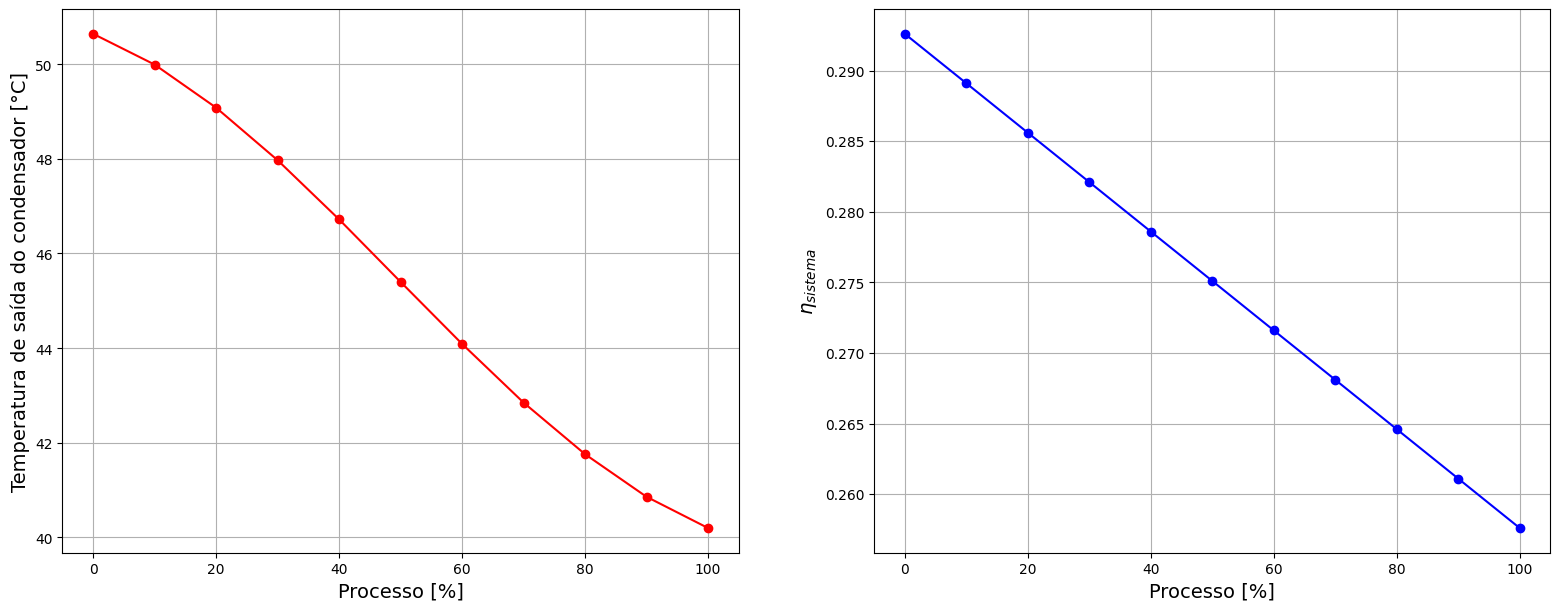

In [ ]:
# Tabela 2:
for i in range(0, quant+1):
  if Temperatura == 'k':
    headers2 = ["%", "m1 [kg/s]", "m2 [kg/s]", "m3 [kg/s]", "m4 [kg/s]", "m5 [kg/s]", "m6 [kg/s]", "m7 [kg/s]", "m8 [kg/s]", "m9 [kg/s]", "m10 [kg/s]", "m11 [kg/s]", "m12 [kg/s]", "T_hout [K]", "W_liq [kJ/s]", "η"]
    resultados2[n+1,i] = round(float(y[i]+273.15),2) #converter para K
    y[i] = resultados2[n+1,i]
  else:
    headers2 = ["%", "m1 [kg/s]", "m2 [kg/s]", "m3 [kg/s]", "m4 [kg/s]", "m5 [kg/s]", "m6 [kg/s]", "m7 [kg/s]", "m8 [kg/s]", "m9 [kg/s]", "m10 [kg/s]", "m11 [kg/s]", "m12 [kg/s]", "T_hout [°C]", "W_liq [kJ/s]", "η"]
    resultados2[n+1,i] = round(float(y[i]),2)
print(tab(table2, headers2, tablefmt="rst", stralign="center", numalign="left"))
print('\nA vazão mássica de combustível é de %.2f kg/s\n' %m_fuel)

# Gráficos:
escala1 = 1.5
plt.figure(dpi=100, figsize=[escala1*2*6.4, escala1*4.8])
plt.subplot(1,2,1)
plt.xlabel('Processo [%]', fontsize=14)
if Temperatura == 'k':
  plt.ylabel('Temperatura de saída do condensador [K]', fontsize=14)
  plt.plot(x, y, color='r', marker = 'o', linestyle = 'solid')
else:
  plt.ylabel('Temperatura de saída do condensador [°C]', fontsize=14)
  plt.plot(x, y, color='r', marker = 'o', linestyle = 'solid')
plt.grid()
plt.subplot(1,2,2)
plt.xlabel('Processo [%]', fontsize=14)
plt.ylabel('$η_{sistema}$', fontsize=14)
plt.plot(x, z, color='b', marker = 'o', linestyle = 'solid')
plt.grid()
plt.show()

## **Gráfico completo Ciclo Rankine**

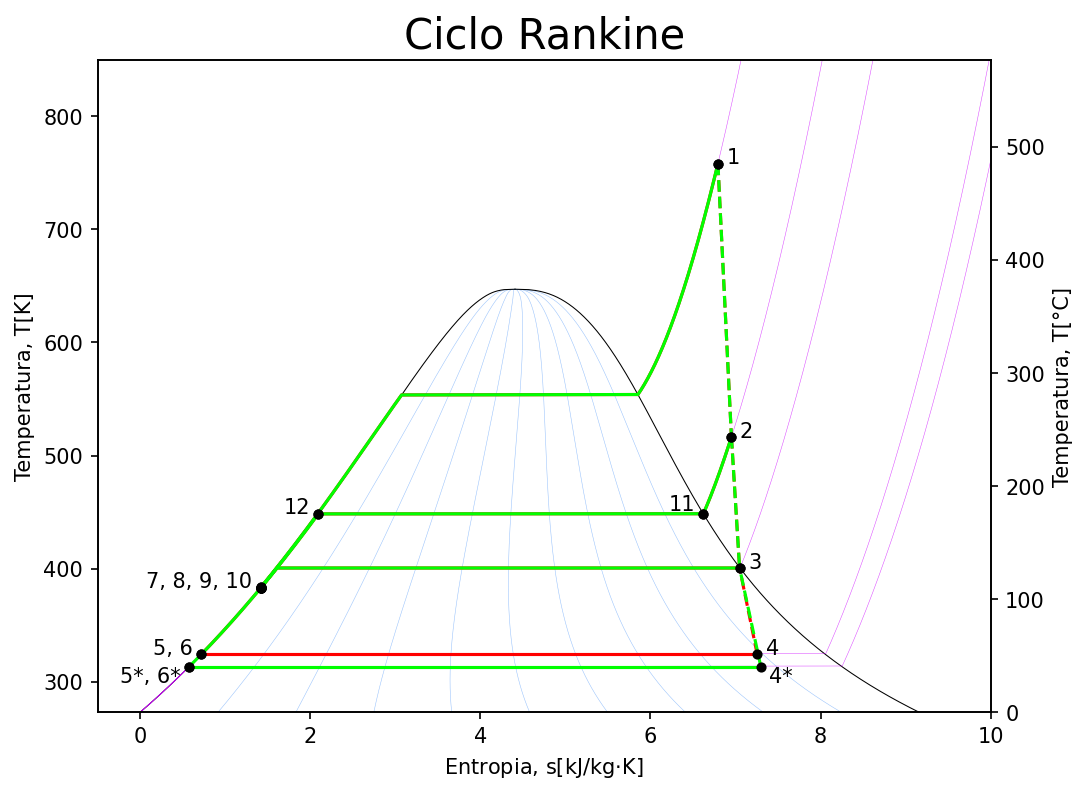

In [ ]:
# Gráfico do Ciclo Rankine:
escala2 = 1.2
plt.figure(dpi=150, figsize=[escala2*6.4, escala2*4.8])
y1 = 273.15
y2 = 850
x1 = -0.5
x2 = 10
plt.ylim(y1,y2)
plt.xlim(x1,x2)
plt.title('Ciclo Rankine',fontsize=20)
plt.xlabel('Entropia, s[kJ/kg$\cdot$K]')
plt.ylabel('Temperatura, T[K]')

Tmin = ps('Tmin',fld )
Tcrit = ps('Tcrit',fld)
Pcrit = ps('Pcrit', fld)

Larg_isolines = .25
Larg_cycle = 1.5
Larg_scatters = 15

#Linhas de entalpia:
T = np.linspace(Tmin,Tcrit,1000)
Q = np.arange(0.1,1,0.1)
for i in Q:
  s = ps('S','T',T,'Q',i,'Water')/1000
  plt.plot(s,T,'#6ca8fa',alpha=0.7,lw=Larg_isolines)

#Domo:
T = np.linspace(Tmin,Tcrit,1000)
s = ps('S','T',T,'Q',0,fld)/1000
plt.plot(s,T,'black',lw=2*Larg_isolines)

T = np.linspace(Tcrit,Tmin,1000)
s = ps('S','T',T,'Q',1,fld)/1000
plt.plot(s,T,'black',lw=2*Larg_isolines)

#Linhas de pressão constante:
T = np.linspace(Tmin,1000,1000)
P = [st_antes[0].p,st_antes[1].p,st_antes[2].p,st_antes[3].p,st_depois[3].p] #P1, P2, P3, P4 e P4*
for i in P:
  s = ps('S','T',T,'P',i*1000,'Water')/1000
  plt.plot(s,T,'#cc00ff',alpha=.7,lw=Larg_isolines)

#Ciclo:
#(antes)
T = np.linspace(st_antes[7].T,st_antes[0].T,1000)
s = ps('S','P',st_antes[0].p * 1000,'T',T,'Water')/1000
plt.plot(s,T,'r',lw=Larg_cycle)

T = np.linspace(st_antes[9].T,st_antes[1].T,1000)
s = ps('S','T',T,'P',st_antes[9].p*1000,'Water')/1000
plt.plot(s,T,'r',lw=Larg_cycle)
plt.plot([st_antes[3].s,st_antes[4].s],[st_antes[3].T,st_antes[4].T],'r',lw=Larg_cycle)

plt.plot([st_antes[0].s,st_antes[1].s],[st_antes[0].T,st_antes[1].T],color='r',linestyle='dashed',lw=Larg_cycle)
plt.plot([st_antes[1].s,st_antes[2].s],[st_antes[1].T,st_antes[2].T],color='r',linestyle='dashed',lw=Larg_cycle)

s = np.linspace(st_antes[2].s,st_antes[6].s,1000)
T = ps('T','S',s*1000,'P',st_antes[2].p*1000,'Water')
plt.plot(s,T,'r',lw=Larg_cycle)

T = np.linspace(st_antes[5].T,st_antes[6].T,1000)
s = ps('S','P',st_antes[5].p*1000,'T',T,'Water')/1000
plt.plot(s,T,'r',lw=Larg_cycle)

s = np.linspace(st_antes[2].s,st_antes[3].s,1000)
plt.plot([st_antes[3].s,st_antes[2].s],[st_antes[3].T,st_antes[2].T],color='r',linestyle='dashed',lw=Larg_cycle)

#(depois)
T = np.linspace(st_depois[7].T,st_depois[0].T,1000)
s = ps('S','P',st_depois[0].p * 1000,'T',T,'Water')/1000
plt.plot(s,T,'lime',lw=Larg_cycle)

T = np.linspace(st_depois[9].T,st_depois[1].T,1000)
s = ps('S','T',T,'P',st_depois[9].p*1000,'Water')/1000
plt.plot(s,T,'lime',lw=Larg_cycle)
plt.plot([st_depois[3].s,st_depois[4].s],[st_depois[3].T,st_depois[4].T],'lime',lw=Larg_cycle)

plt.plot([st_depois[0].s,st_depois[1].s],[st_depois[0].T,st_depois[1].T],color='lime',linestyle='dashed',lw=Larg_cycle)
plt.plot([st_depois[1].s,st_depois[2].s],[st_depois[1].T,st_depois[2].T],color='lime',linestyle='dashed',lw=Larg_cycle)

s = np.linspace(st_depois[2].s,st_depois[6].s,1000)
T = ps('T','S',s*1000,'P',st_depois[2].p*1000,'Water')
plt.plot(s,T,'lime',lw=Larg_cycle)

T = np.linspace(st_depois[5].T,st_depois[6].T,1000)
s = ps('S','P',st_depois[5].p*1000,'T',T,'Water')/1000
plt.plot(s,T,'lime',lw=Larg_cycle)

s = np.linspace(st_depois[2].s,st_depois[3].s,1000)
plt.plot([st_depois[3].s,st_depois[2].s],[st_depois[3].T,st_depois[2].T],color='lime',linestyle='dashed',lw=Larg_cycle)

#Pontuar e nomear:
for i in range(0, n):
  plt.scatter(st_antes[i].s,st_antes[i].T,zorder=5,color='k',s=Larg_scatters)
  plt.scatter(st_depois[i].s,st_depois[i].T,zorder=5,color='k',s=Larg_scatters)

plt.text(st_antes[0].s+.1,st_antes[0].T,'1',ha='left')
plt.text(st_antes[1].s+.1,st_antes[1].T,'2',ha='left')
plt.text(st_antes[2].s+.1,st_antes[2].T,'3',ha='left')
plt.text(st_antes[3].s+.1,st_antes[3].T,'4',ha='left')
plt.text(st_antes[4].s-.1,st_antes[4].T,'5, 6',ha='right')
plt.text(st_antes[6].s-.1,st_antes[6].T,'7, 8, 9, 10',ha='right')
plt.text(st_antes[10].s-.1,st_antes[10].T,'11',va='bottom',ha='right')
plt.text(st_antes[11].s-.1,st_antes[11].T+.1,'12',ha='right')
plt.text(st_depois[3].s+.1,st_depois[3].T,'4*',va='top',ha='left')
plt.text(st_depois[4].s-.1,st_depois[4].T,'5*, 6*',va='top',ha='right')

#plt.grid(lw=Larg_isolines)
plt.twinx()
plt.ylim(y1-273.15,y2-273.15)
plt.ylabel('Temperatura, T[°C]')
#plt.grid(lw=Larg_isolines)

plt.savefig('Diagrama T-s.png')
#files.download('Diagrama T-s.png')

## **Tabela relatório completo Ciclo Rankine**

In [ ]:
#@title Texto de título padrão
# Tabela 3:
table3 = STT_T + STT_P + STT_X + STT_h + STT_s + STT_v
headers3=["Propriedade", "%", "Estado 1", "Estado 2", "Estado 3", "Estado 4", "Estado 5", "Estado 6", "Estado 7", "Estado 8", "Estado 9", "Estado 10", "Estado 11", "Estado 12"]

print(tab(table3, headers3, tablefmt="rst", stralign="center", numalign="center"))

========================  =====  ==========  ==========  ==========  ==========  ==========  ==========  ==========  ==========  ==========  ===========  ===========  ===========
      Propriedade           %     Estado 1    Estado 2    Estado 3    Estado 4    Estado 5    Estado 6    Estado 7    Estado 8    Estado 9    Estado 10    Estado 11    Estado 12
========================  =====  ==========  ==========  ==========  ==========  ==========  ==========  ==========  ==========  ==========  ===========  ===========  ===========
    Temperatura [°C]       0.0     485.0       243.27      127.41      50.64       50.64       50.66       110.0       -162.4      110.0       110.08       175.35       175.35
    Temperatura [°C]      10.0     485.0       243.27      127.41      49.99       49.99       50.01       110.0       -162.4      110.0       110.08       175.35       175.35
    Temperatura [°C]      20.0     485.0       243.27      127.41      49.08       49.08        49.1       110.0